In [1]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# 予測結果の精度確認（ROC曲線の描画）
from sklearn.metrics import roc_auc_score, roc_curve
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
# 特徴量選択
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# 多項式・交互作用特徴量
from sklearn.preprocessing import PolynomialFeatures
import math

In [2]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset, Dataset

In [3]:
class MedcTrainDataset(Dataset):
    def __init__(self):
        super().__init__()
        
        # CSVファイル読み込み（訓練データ）
        df = pd.read_csv('train.csv')
        
        df_x = df.drop(['disease'], axis=1)
        self.df_y = df.loc[:,['disease']]
        
        self.x_desc = df_x.describe()
        self.x_cate , self.x_cont = self.MedcDataChange(df_x)

        self.std_scale = 0
        self.max_scale = 0
        self.dobule_scale = 0
        self.polynomialFlg = 0
        self.binSplitFlg = 0
        self.DataConv()
        
        self.num = len(self.X_train)

    def __getitem__(self, index):
        return self.X_train[index], self.Y_train[index]
    
    def __len__(self):
        return self.num
    
    def MedcDataChange(self, df_x):
        categ_cols = ['Age','Gender']
        contin_cols = ['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio']

        ####################################
        ##  データ分割
        ##  説明変数と目的変数に分ける。
        ##  説明変数はカテゴリデータと連続データに分ける。
        ####################################
        x_cate = df_x[categ_cols].copy()
        x_cont = df_x[contin_cols].copy()

        ####################################
        ##  カテゴリデータ
        ##  値変換
        ####################################

        # --------------------------------------
        # Ageの変換の変換
        # '0'  ～18歳未満
        # '1'  18歳～25歳未満
        # '2'  25歳～30歳未満
        # '3'  30歳～35歳未満
        # '4'  35歳～40歳未満
        # '5'  40歳～50歳未満
        # '6'  50歳～60歳未満
        # '7'  60歳～70歳未満
        # '8'  70歳～80歳未満
        # '9'  80歳～
        bins = [0, 18, 25, 30, 35, 40, 50, 60, 70, 80 ,1000]
        #X_cut = pd.cut(x_cate['Age'], bins=bins, labels=['Age' + str(x) for x in range(len(bins)-1)])
        X_cut = pd.cut(x_cate['Age'], bins=bins, labels=False)
        cutTemp = np.zeros((len(X_cut), len(bins) -1 ), dtype=int)
        cutTemp[np.arange(len(X_cut)), X_cut.T] = 1
        df_cut=pd.DataFrame(cutTemp ,columns=['Age' + str(x) for x in range(cutTemp.shape[1])])
        # 列の削除
        x_cate.drop(columns=['Age'], inplace=True, axis=1)
        # 列の追加
        x_cate = pd.concat([x_cate, df_cut], axis=1)

        # --------------------------------------
        # 性別を変換する
        colval=['Female','Male']
        # 初期値０の列を作成する
        for col in colval:
            x_cate[col]=0

        # カテゴリ毎に値編集
        for col in colval:
            x_cate.loc[x_cate['Gender']==col, col]=1
        x_cate.drop(columns=['Gender'],inplace=True)

        return x_cate , x_cont

    
    def NpToPy(self):
        
        #x_temp = pd.concat([self.x_cate , self.x_cont] , axis=1)
        x_temp = self.x_cont.copy()
        x_temp = np.array(x_temp)
        y_temp = np.array(self.df_y)
        
        # 訓練データと検証データに分割
        x_train,x_test,y_train,y_test=train_test_split(x_temp, y_temp, test_size=0.2, random_state=3) 
        
        # numpy の値を torch の値に変換する
        self.X_train = torch.from_numpy(x_train).float()
        self.Y_train = torch.from_numpy(y_train).float()
        self.X_test = torch.from_numpy(x_test).float()
        self.Y_test = torch.from_numpy(y_test).float()
        
        self.coti_size = self.x_cont.shape[1]
        self.in_size  = self.X_train.shape[1]
        self.out_size = self.Y_train.shape[1]
        #self.x_desc = self.x_cont.describe()
        
    def StdScale(self):
        
        if (self.std_scale == 0):
            bai = 3
            
            col='T_Bil'
            std=self.x_desc.loc['75%',col]*bai
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            self.x_cont.loc[self.x_cont[col]>std , col]=std
            
            col='D_Bil'
            std=self.x_desc.loc['75%',col]*bai
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            #col='ALP'
            #std=self.x_desc.loc['75%',col]*bai
            #std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            #self.x_cont.loc[self.x_cont[col]<std , col]=std
            
            col='ALT_GPT'
            std=self.x_desc.loc['75%',col]*bai
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            #std=60
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            col='AST_GOT'
            std=self.x_desc.loc['75%',col]*bai
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            #std=140
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            col='Alb'
            std=self.x_desc.loc['75%',col]*bai
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            #std=4.5
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            col='AG_ratio'
            std=self.x_desc.loc['75%',col]*bai
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            #std=1.7
            self.x_cont.loc[self.x_cont[col]>std , col]=std


            col='TP'
            std=5.5
            self.x_cont.loc[self.x_cont[col]<std , col]=std

            self.std_scale = 1
            self.NpToPy()
        
    def MaxScale(self):
        
        if (self.max_scale == 0):
            col='T_Bil'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='D_Bil'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='ALP'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='ALT_GPT'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='AST_GOT'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='TP'
            maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval
            self.x_cont.loc[:,col]=1-self.x_cont.loc[:,col]

            col='Alb'
            maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval
            self.x_cont.loc[:,col]=1-self.x_cont.loc[:,col]

            col='AG_ratio'
            maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval
            self.x_cont.loc[:,col]=1-self.x_cont.loc[:,col]

            self.max_scale = 1
            self.NpToPy()

    def DobuleScale(self):
        
        if (self.dobule_scale == 0):
            col='T_Bil'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='D_Bil'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='ALP'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='ALT_GPT'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='AST_GOT'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='TP'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]
            
            col='Alb'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]
            
            col='AG_ratio'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]
            
            self.dobule_scale = 1
            self.NpToPy()
            
    def PolynomialTrance(self):
        if (self.polynomialFlg == 0):
            col1='T_Bil'
            col2='D_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='T_Bil'
            col2='ALP'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='D_Bil'
            col2='ALP'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='ALT_GPT'
            col2='AST_GOT'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='ALT_GPT'
            col2='T_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='ALT_GPT'
            col2='D_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='ALT_GPT'
            col2='ALP'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='AST_GOT'
            col2='T_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='AST_GOT'
            col2='D_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='AST_GOT'
            col2='ALP'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='TP'
            col2='Alb'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='TP'
            col2='AG_ratio'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='Alb'
            col2='AG_ratio'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            self.polynomialFlg = 1
            self.NpToPy()
        
    def snsPlot(self):
        
        # seabornで相関係数を描画
        plt.figure(figsize=(15,15))
        df_sns = pd.concat([self.x_cont , self.df_y] , axis=1)
        sns.heatmap(df_sns.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
        plt.show()
           
    def boxPlot(self):
        
        df_sns = pd.concat([self.x_cont , self.df_y] , axis=1)
        
        fig, ax = plt.subplots(3,3,figsize=(20,20))
        sns.boxplot(x="disease",y="T_Bil",data=df_sns,ax=ax[0][0])
        sns.boxplot(x="disease",y="D_Bil",data=df_sns,ax=ax[0][1])
        sns.boxplot(x="disease",y="ALP",data=df_sns,ax=ax[0][2])
        sns.boxplot(x="disease",y="ALT_GPT",data=df_sns,ax=ax[1][0])
        sns.boxplot(x="disease",y="AST_GOT",data=df_sns,ax=ax[1][1])
        sns.boxplot(x="disease",y="TP",data=df_sns,ax=ax[1][2])
        sns.boxplot(x="disease",y="Alb",data=df_sns,ax=ax[2][0])
        sns.boxplot(x="disease",y="AG_ratio",data=df_sns,ax=ax[2][1])
        plt.tight_layout()
    
    def binSplit(self):
        if self.binSplitFlg == 0:
            contin_cols = ['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio']
            
            for col in contin_cols:
                split_min = 0
                split_min2 = self.x_desc.loc['min',col]*10
                split_min3 = self.x_desc.loc['min',col]
                split1 = self.x_desc.loc['25%',col]
                split2 = self.x_desc.loc['50%',col]
                split3 = self.x_desc.loc['75%',col]
                split4 = self.x_desc.loc['25%',col]*2
                split5 = self.x_desc.loc['75%',col]/2
                #std_m = self.x_desc.loc['std',col]/3
                #std_m = 0
                std_m = self.x_desc.loc['25%',col]/2
                #std_p = self.x_desc.loc['std',col]*3
                #std_p = 0
                std_p = self.x_desc.loc['75%',col]*2
                #split_max=  self.x_desc.loc['max',col]
                split_max = 0
                split_max2=  self.x_desc.loc['max',col]*10
                bins = [split_min,  split_min2, split_min3, split1,  split2,  split3, split4,  split5, std_m,  std_p,  split_max, split_max2]
                
                bins = np.sort(list(set(bins)))
                #print(col , ':' , desc.loc[:,col])
                #print(col, ':', bins)
                #print('----------')
                self.x_cont[col] = pd.cut(self.x_cont[col], bins=bins, labels=False)
                
                self.binSplitFlg = 1
                self.NpToPy()
        
    def DataConv(self):
        #self.StdScale()
        #self.DobuleScale()
        self.binSplit()
        
        #self.MaxScale()
        #self.PolynomialTrance()
        
        
        

In [4]:
class MedcTestDataset(MedcTrainDataset):
    def __init__(self, x_desc):
        
        # CSVファイル読み込み（訓練データ）
        df = pd.read_csv('test.csv')

        self.x_desc = x_desc
        self.x_cate , self.x_cont = self.MedcDataChange(df.copy())
        
        self.std_scale = 0
        self.max_scale = 0
        self.dobule_scale = 0
        self.polynomialFlg = 0
        self.binSplitFlg = 0
        self.DataConv()
        
        self.num = len(self.x_cate)

    def __getitem__(self, index):
        return self.X_test[index]
    
    def __len__(self):
        return self.num
    
    def NpToPy(self):
        
        #x_temp = pd.concat([self.x_cate , self.x_cont] , axis=1)
        x_temp = self.x_cont.copy()
        x_temp = np.array(x_temp)
        
        # numpy の値を torch の値に変換する
        self.X_vat = torch.from_numpy(x_temp).float()

    def snsPlot(self):
        
        # seabornで相関係数を描画
        plt.figure(figsize=(15,15))
        df_sns = self.x_cont
        
        sns.heatmap(df_sns.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
        plt.show()
        
    def boxPlot(self, y = [0]):
        
        df_sns = self.x_cont.copy()
        if len(y) == 1:
            df_sns['disease'] = '0'
        else:
            df_sns['disease'] = y
        
        fig, ax = plt.subplots(3,3,figsize=(20,20))
        sns.boxplot(x="disease",y="T_Bil",data=df_sns,ax=ax[0][0])
        sns.boxplot(x="disease",y="D_Bil",data=df_sns,ax=ax[0][1])
        sns.boxplot(x="disease",y="ALP",data=df_sns,ax=ax[0][2])
        sns.boxplot(x="disease",y="ALT_GPT",data=df_sns,ax=ax[1][0])
        sns.boxplot(x="disease",y="AST_GOT",data=df_sns,ax=ax[1][1])
        sns.boxplot(x="disease",y="TP",data=df_sns,ax=ax[1][2])
        sns.boxplot(x="disease",y="Alb",data=df_sns,ax=ax[2][0])
        sns.boxplot(x="disease",y="AG_ratio",data=df_sns,ax=ax[2][1])
        plt.tight_layout()

## 訓練データの読み込み

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


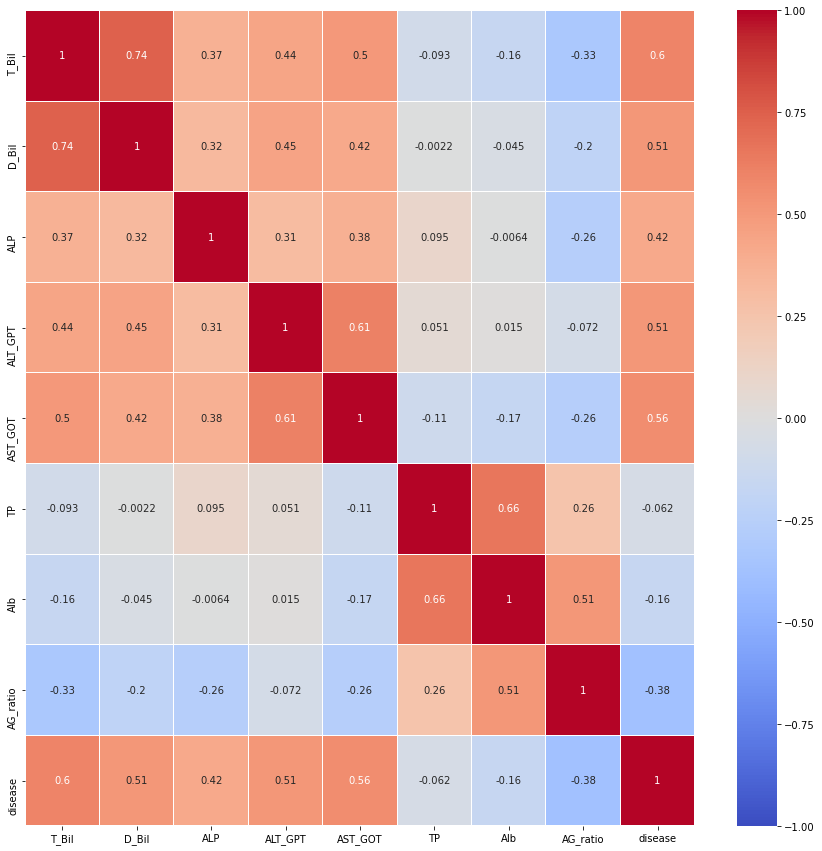

In [5]:
train_dataset = MedcTrainDataset()
total_samples = len(train_dataset)
train_dataset.snsPlot()

In [6]:
train_dataset.x_desc

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,46.610588,1.607337,0.606737,272.211316,41.978476,61.018120,7.032290,3.517458,1.144570
std,16.453672,2.443585,1.569032,200.348515,145.927366,110.125390,0.840664,0.559942,0.227237
min,10.000000,0.585961,0.034861,163.261838,3.924518,11.283497,4.858679,2.180884,0.627133
25%,32.000000,0.781258,0.144889,213.991414,13.644658,21.239157,6.730612,3.139153,1.004466
50%,48.000000,0.835591,0.194085,220.092503,16.638001,27.056026,6.915580,3.621339,1.205016
75%,62.000000,1.196759,0.335447,229.455927,23.056081,56.461568,7.536151,3.712524,1.287880
max,78.000000,23.017027,17.692164,2108.483728,1423.186473,814.439397,8.739000,5.016970,1.821496


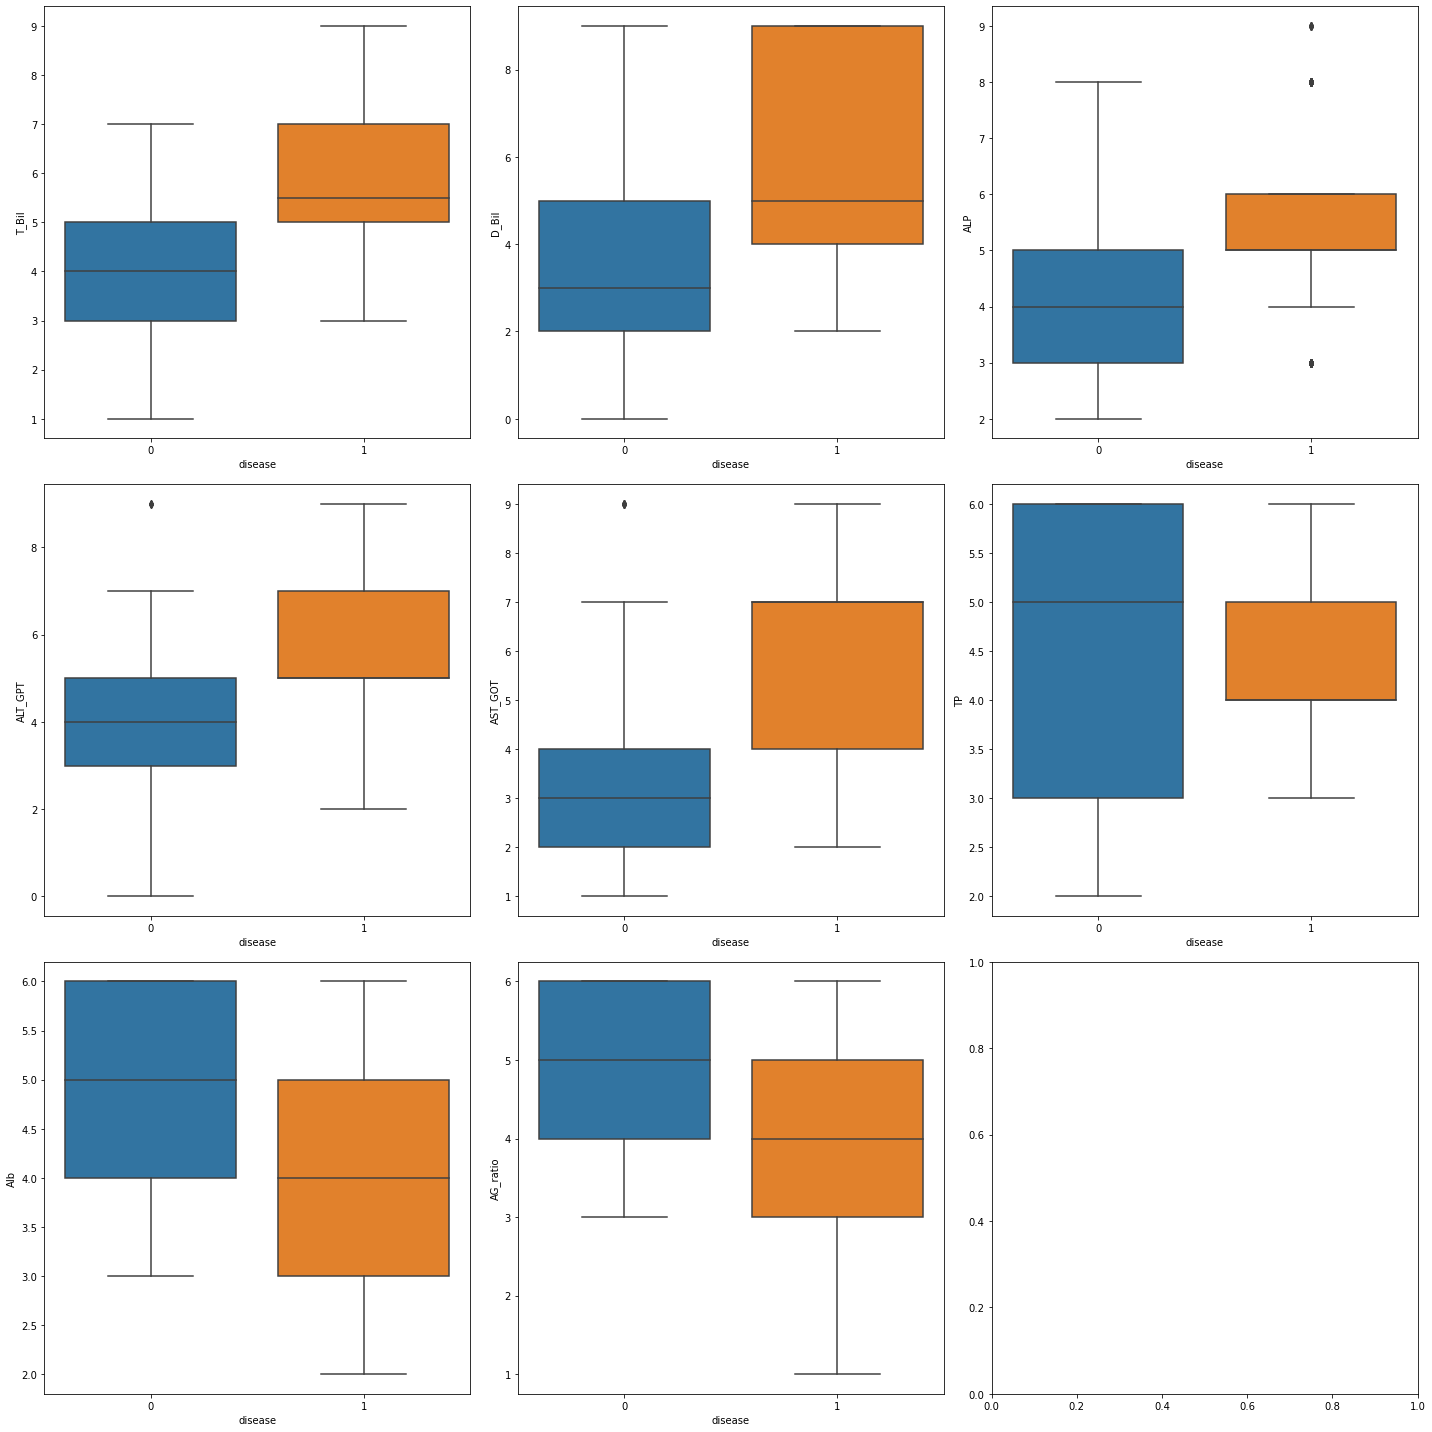

In [7]:
train_dataset.boxPlot()

In [8]:
train_dataset.x_cont.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,4.847059,4.781176,4.618824,4.735294,4.516471,4.498824,4.498824,4.495294
std,1.731070,2.499776,1.368714,1.942471,2.294118,1.121846,1.121846,1.129162
min,1.000000,0.000000,2.000000,0.000000,1.000000,2.000000,2.000000,1.000000
25%,3.250000,2.250000,3.250000,3.250000,2.250000,3.250000,3.250000,3.250000
50%,4.500000,4.500000,4.500000,4.500000,3.500000,4.500000,4.500000,4.500000
75%,5.750000,6.750000,5.750000,5.750000,6.750000,5.750000,5.750000,5.750000
max,9.000000,9.000000,9.000000,9.000000,9.000000,6.000000,6.000000,6.000000


## 評価データの読み込み

In [9]:
test_dataset = MedcTestDataset(train_dataset.x_desc)

In [10]:
test_dataset.x_cont.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,4.837143,4.677143,4.717143,4.691429,4.320000,4.554286,4.497143,4.528571
std,1.661736,2.350710,1.427320,1.848622,2.250858,1.148649,1.149931,1.103802
min,3.000000,1.000000,3.000000,2.000000,1.000000,3.000000,3.000000,3.000000
25%,4.000000,3.000000,4.000000,3.000000,2.000000,3.250000,3.000000,4.000000
50%,5.000000,4.500000,5.000000,4.000000,3.000000,5.000000,4.000000,5.000000
75%,5.000000,5.000000,6.000000,5.000000,6.000000,6.000000,6.000000,6.000000
max,9.000000,9.000000,9.000000,9.000000,9.000000,6.000000,6.000000,6.000000


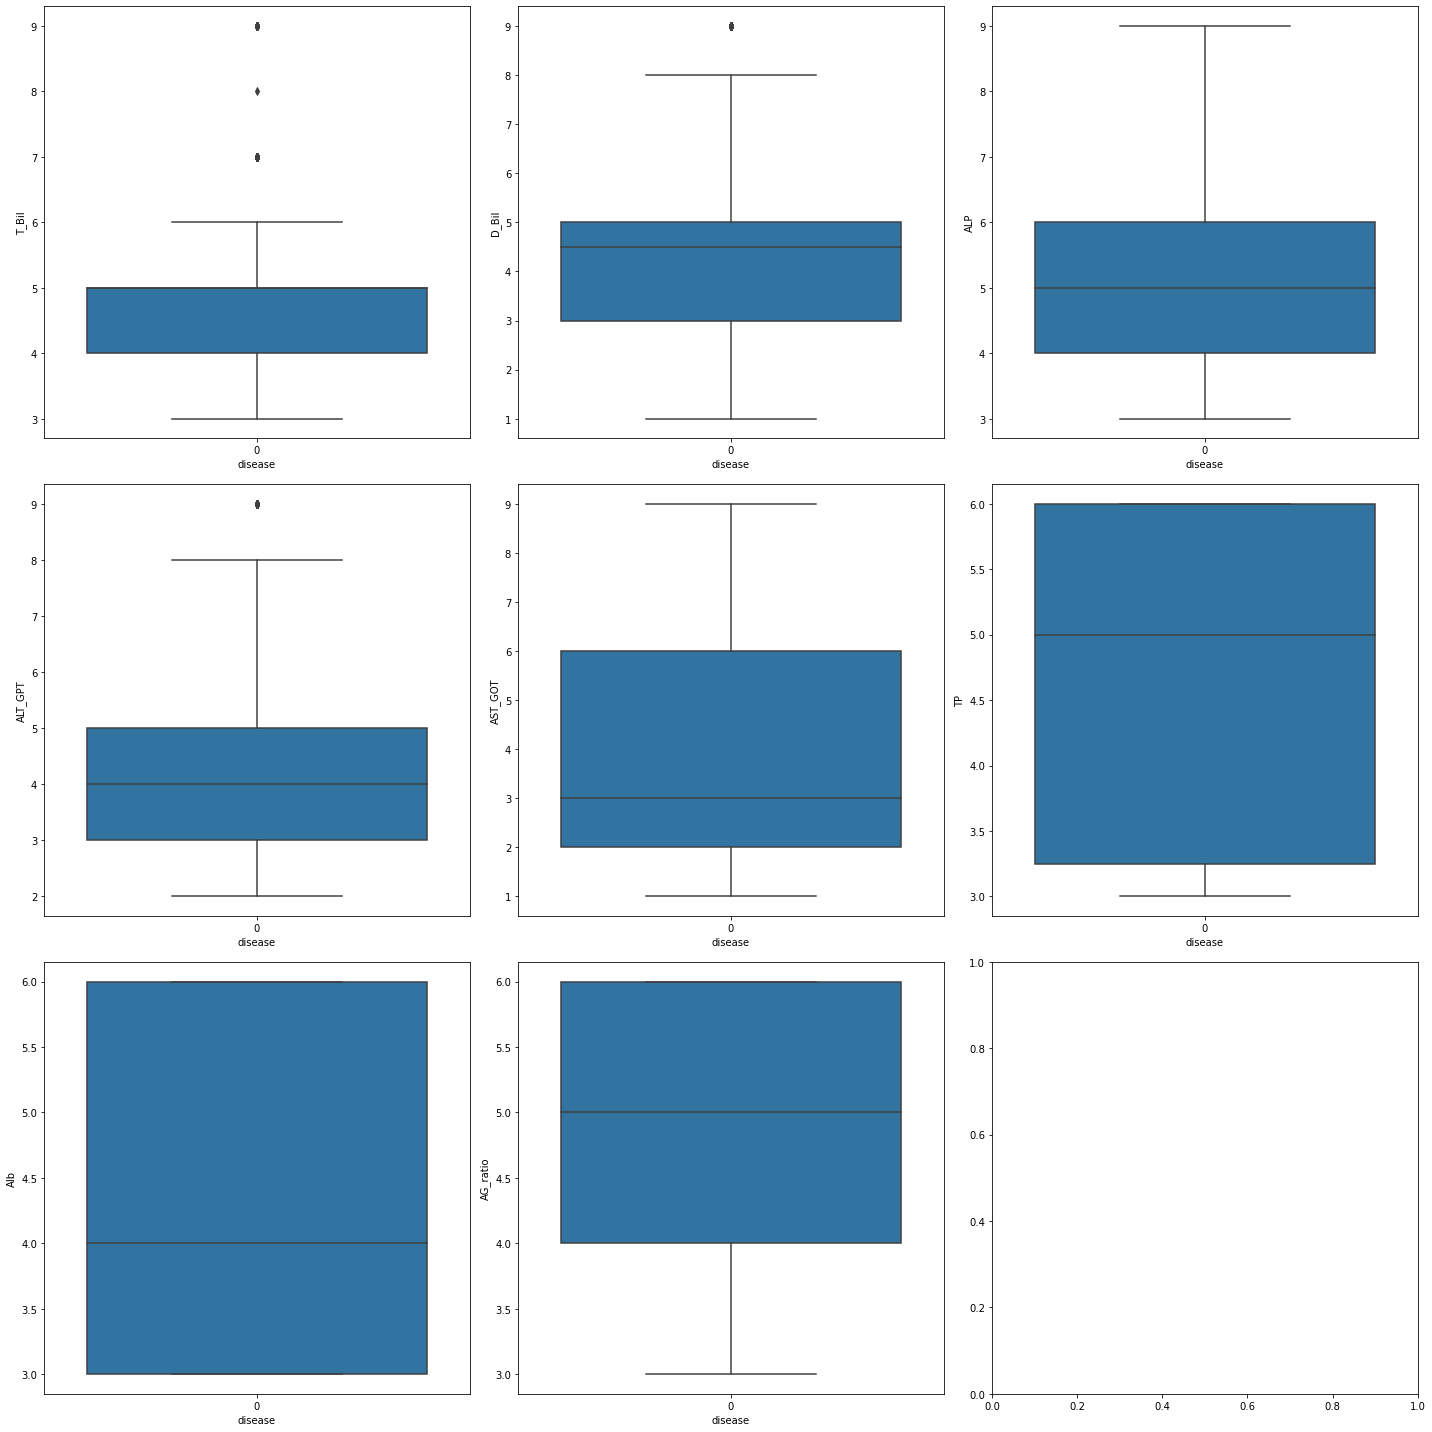

In [11]:
test_dataset.boxPlot()

# モデル定義（分類）

In [12]:
batchsize=100

# batch_size ：学習する時にまとめるデータ数
# shuffle    : データをランダムに並び替える場合はTrue
#train_loader = DataLoader(train ,batch_size=30, shuffle=True, num_workers=2)
train_loader = DataLoader(dataset=train_dataset ,batch_size=batchsize, shuffle=True)

In [13]:
node1=25
node2=8


# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net1(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net1 ,self).__init__()
        # ドロップアウト
        p=0.5
        self.dropout1 = nn.Dropout(p)
        self.dropout2 = nn.Dropout(p)
        
        # バッチ正規化
        self.bn_cont = nn.BatchNorm1d(train_dataset.coti_size)
        
        # 全結合層
        self.fc1 = nn.Linear(train_dataset.in_size , node1)         # nn.Linear (入力のノード数 , 中間層ノード数)
        self.fc2 = nn.Linear(node1 , node2)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc3 = nn.Linear(node2,  train_dataset.out_size)        # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
#        x = torch.relu(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
#        x = F.sigmoid(self.fc2(x))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る

        # バッチ正規化
        x = self.bn_cont(x)
        
        x = torch.sigmoid (self.fc1(x))           # 入力のノードを中間層（１階層目）に渡して結果を得る
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))           # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))           # 中間層（２階層目）の結果を出力層に渡す
        return x

In [14]:
# モデルの定義
model1 = Net1()
# 損失の定義 (平均二乗誤差)
criterion1 = nn.BCELoss()
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
optimizer1 = optim.Adam(model1.parameters() , lr=0.005)

In [15]:
loss_list1 = []
accuracy_list1 = []

correct_counter1 = 0
logdisp=100
#acccnt=len(train_dataset)*logdisp
acccnt=batchsize*logdisp
print('rec_cnt', acccnt)
epochs=1000
mathcnt = 0

# トレーニングの回数分ループする。
for epoch in range(epochs):
    # 損失を初期化　
    total_loss1 = 0
    
    for x_train , y_train in train_loader:

        # 出力を計算する 
        output1 = model1(x_train)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss1 = criterion1(output1 ,y_train)
        
        correct_temp = roc_auc_score(y_true=y_train.numpy(), y_score=output1.data.numpy())
        correct_counter1 += correct_temp
        mathcnt += 1

        
        # パラメータの勾配を初期化する
        optimizer1.zero_grad()
        # ロスを伝播する
        loss1.backward()
        # パラメータを更新する
        optimizer1.step()

        # トータルロスを格納
        total_loss1 += loss1.item()
        
        
    
    # 回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_tmp1=total_loss1/acccnt
        print(f'Epoch\t{epoch+1}\tLoss\t{loss_tmp1:.8f}\taccu:\t{correct_counter1*100/mathcnt:.3f}%')
        
        
        accuracy_list1.append(correct_counter1.item()*100/(mathcnt))
        loss_list1.append(loss_tmp1)
        total_loss=0
        correct_counter1 = 0
        mathcnt = 0
        

rec_cnt 10000
Epoch	100	Loss	0.00028222	accu:	86.133%
Epoch	200	Loss	0.00027459	accu:	90.427%
Epoch	300	Loss	0.00026922	accu:	91.288%
Epoch	400	Loss	0.00025538	accu:	91.650%
Epoch	500	Loss	0.00027059	accu:	91.875%
Epoch	600	Loss	0.00025158	accu:	92.066%
Epoch	700	Loss	0.00024209	accu:	92.354%
Epoch	800	Loss	0.00024359	accu:	92.345%
Epoch	900	Loss	0.00024374	accu:	92.359%
Epoch	1000	Loss	0.00022785	accu:	92.424%


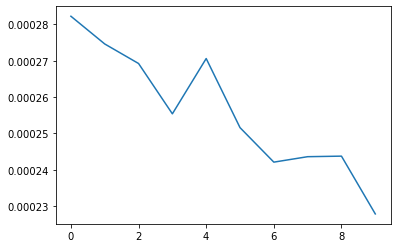

In [16]:
# ロスのプロット
plt.plot(loss_list1)

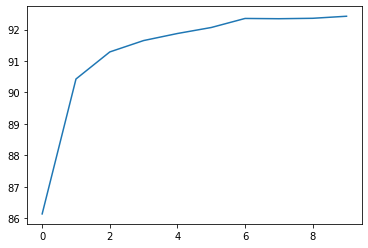

In [17]:
plt.plot(accuracy_list1)

## 誤差の確認

In [18]:
#print(Y_test)

In [19]:
# 学習を行わないモードに変更
model1.eval()


y_hat=model1(train_dataset.X_test).data
y_hat=y_hat.numpy()

y_hat2=y_hat.round()

y_true=train_dataset.Y_test.numpy()


accuracy = np.sum(y_true == y_hat2) /len(y_true)
print(accuracy)


0.8647058823529412


## ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）

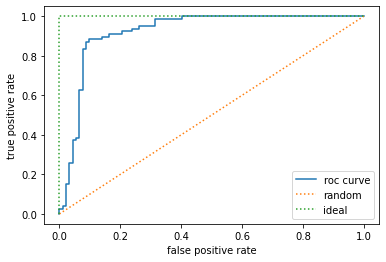

[1.9403954  0.9403953  0.9395499  0.93929523 0.9389177  0.9386828
 0.93516046 0.93509465 0.93485737 0.93485725 0.9348568  0.93485665
 0.93435735 0.93411523 0.9339602  0.9328382  0.88626647 0.86027426
 0.55145395 0.55138624 0.5513588  0.55135554 0.5513456  0.55125725
 0.55106336 0.5276662  0.52265984 0.4546318  0.40990543 0.39308172
 0.38982847 0.30599138 0.2862076  0.20389442 0.08751865 0.05469168
 0.05005441 0.0053621  0.00530025 0.00494699 0.0049279  0.00489784]


In [20]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_hat)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print(thresholds)

In [21]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_true, y_score=y_hat)
print("AUC:", auc_score*100)

AUC: 92.19620958751393


#  予測する

In [448]:
y_predict=model1(test_dataset.X_vat).data
y_predict=y_predict.numpy()

print(y_predict)
y_predict = y_predict
df_out = pd.DataFrame(np.array(y_predict ,dtype=np.float32), columns=['val'])

df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False)


[[0.03034793]
 [0.09005156]
 [0.04295851]
 [0.0309804 ]
 [0.04129741]
 [0.25339103]
 [0.95291054]
 [0.31939256]
 [0.68040806]
 [0.26805136]
 [0.267886  ]
 [0.03832978]
 [0.27019563]
 [0.95291054]
 [0.03107298]
 [0.24528383]
 [0.9521589 ]
 [0.03941819]
 [0.04255094]
 [0.02960447]
 [0.5961594 ]
 [0.0294811 ]
 [0.13987973]
 [0.68202376]
 [0.11351673]
 [0.06340329]
 [0.2071883 ]
 [0.95290333]
 [0.28214574]
 [0.95286727]
 [0.3746797 ]
 [0.9528808 ]
 [0.03392725]
 [0.25616142]
 [0.9529105 ]
 [0.9529105 ]
 [0.03571202]
 [0.2763515 ]
 [0.03068322]
 [0.95291   ]
 [0.4475446 ]
 [0.22448896]
 [0.63132924]
 [0.29525   ]
 [0.26475373]
 [0.30308035]
 [0.04295851]
 [0.95286304]
 [0.27182993]
 [0.69716597]
 [0.89345765]
 [0.2600106 ]
 [0.95290256]
 [0.26904714]
 [0.26821545]
 [0.03034774]
 [0.7236191 ]
 [0.09964705]
 [0.95291054]
 [0.26500708]
 [0.41009703]
 [0.03016694]
 [0.95291054]
 [0.03284459]
 [0.09919252]
 [0.15549117]
 [0.93015885]
 [0.9508623 ]
 [0.26809347]
 [0.02931705]
 [0.95134735]
 [0.26

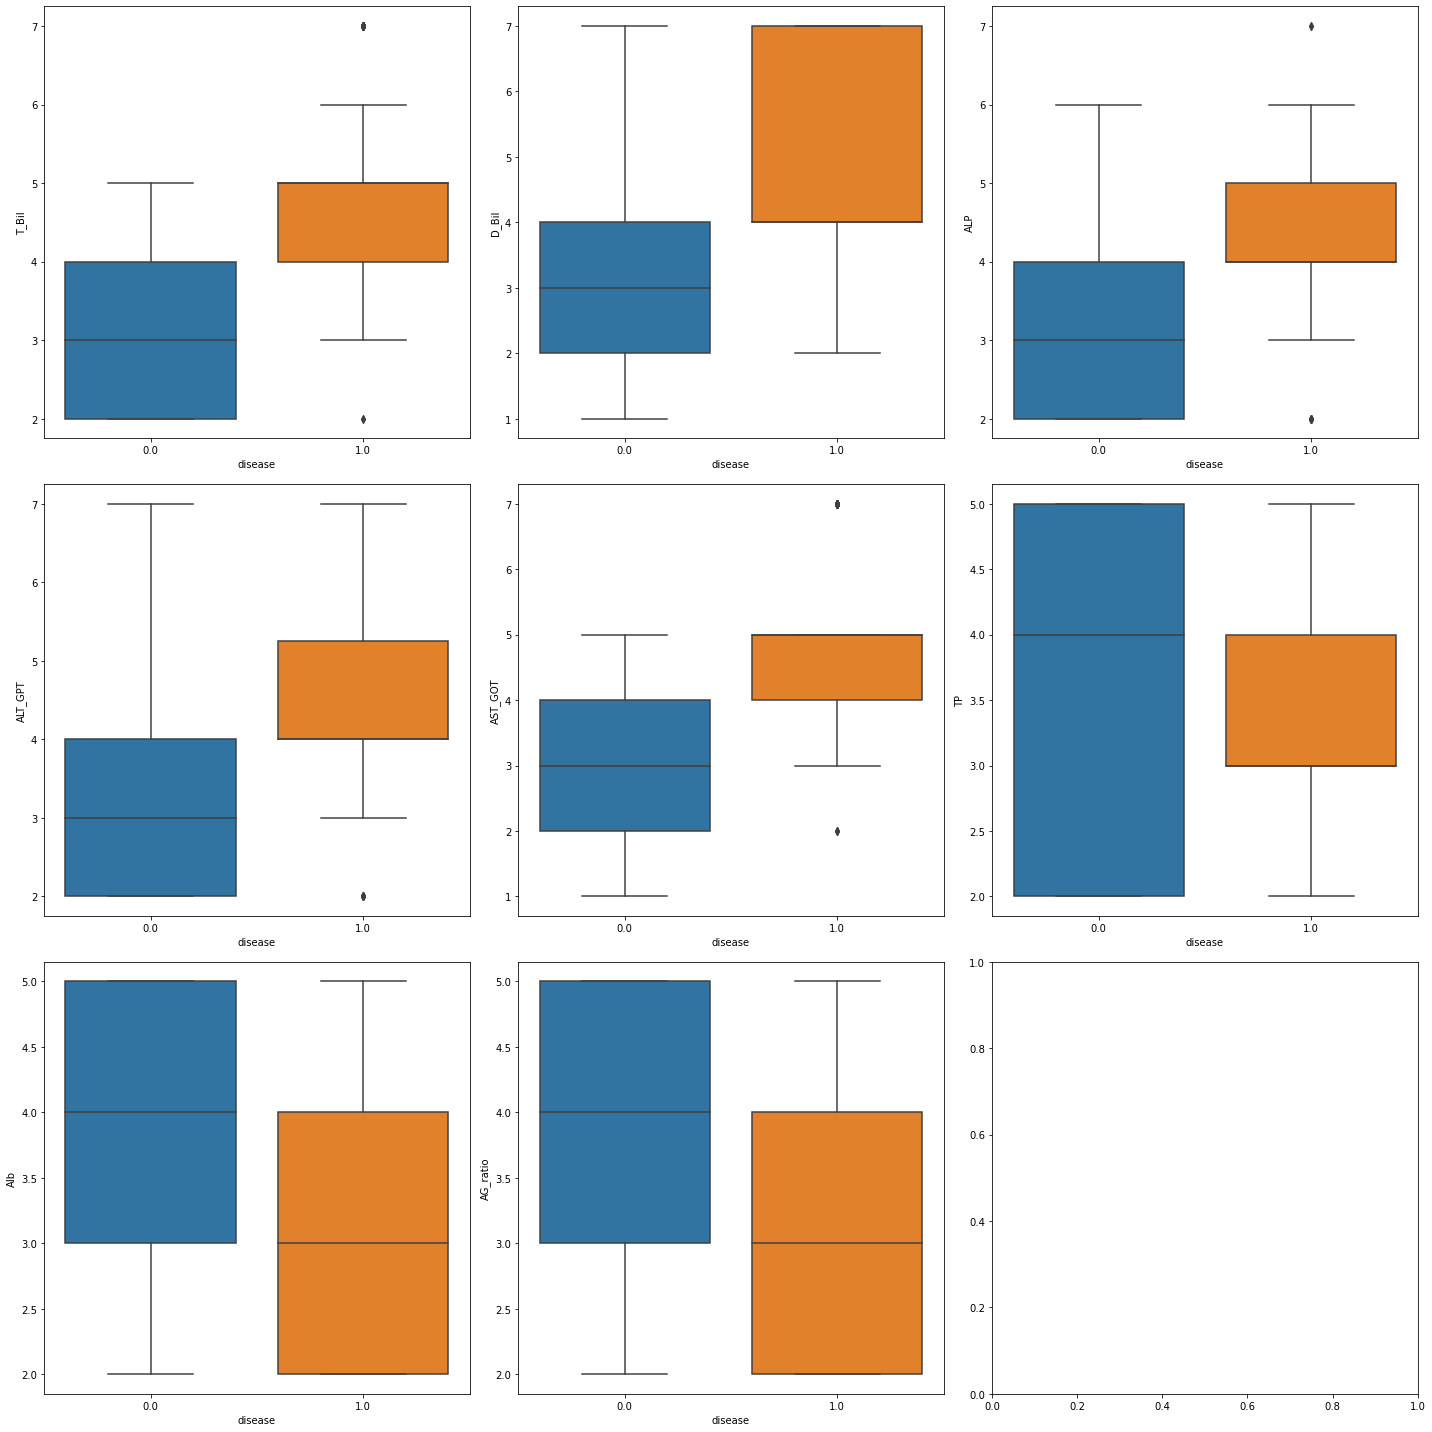

In [449]:
test_dataset.boxPlot(y_predict.round())

# モデルの保存

In [29]:
#model_path = 'model1.pth'
#torch.save(model1.to('cpu').state_dict(), model_path)
#model_path = 'model2.pth'
#torch.save(model2.to('cpu').state_dict(), model_path)